# Understanding the Amazon from Space 

### Objective:
Label satellite image chips with atmospheric conditions and various classes of land cover/land use. 

Available labels are: *agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water*

In [5]:
# imports
import pandas as pd
import numpy as np
import os
import matplotlib.image as image
import matplotlib.pyplot as plt
import rasterio
from IPython.display import display
%matplotlib inline

In [7]:
PLANET_KAGGLE_ROOT = os.path.abspath("../input/amazon")
PLANET_KAGGLE_TIFF_DIR = os.path.join(PLANET_KAGGLE_ROOT, './train-tif/')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, './train.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

### 1. Training Label Analysis

In [8]:
# read our data and take a look at what we are dealing with
train_csv = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
train_csv.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
# how much data do we have?
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40479 entries, 0 to 40478
Data columns (total 2 columns):
image_name    40479 non-null object
tags          40479 non-null object
dtypes: object(2)
memory usage: 632.6+ KB


#### Observations
- First objective will be to extract and and split the tag data into binary feature columns to be analyzed seperately.

In [10]:
AVAILABLE_LABELS = [
    'agriculture', 
    'artisinal_mine', 
    'bare_ground', 
    'blooming', 
    'blow_down', 
    'clear', 
    'cloudy', 
    'conventional_mine', 
    'cultivation', 
    'habitation', 
    'haze', 
    'partly_cloudy', 
    'primary', 
    'road', 
    'selective_logging', 
    'slash_burn', 
    'water']

tags = pd.DataFrame()

for label in AVAILABLE_LABELS:
    tags[label] = train_csv.tags.apply(lambda x: np.where(label in x, 1, 0))
    
train = pd.concat([train_csv, tags], axis=1)
train.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,haze primary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,clear primary,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture clear habitation primary road,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


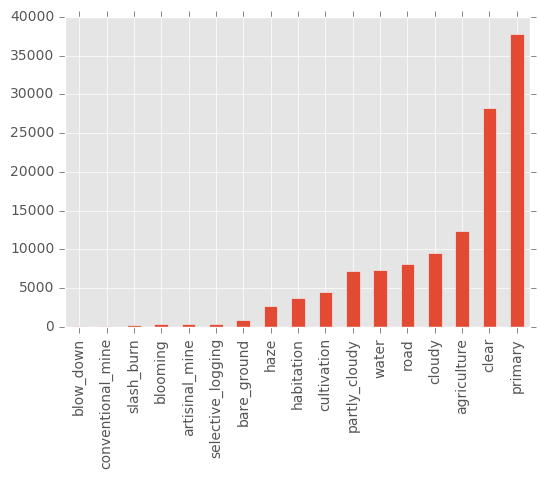

In [6]:
plt.style.use('ggplot')

train.drop(['image_name', 'tags'], 1).sum().sort_values().plot(kind='bar')

#### Observations
- Some labels have almost no samples
- The 'primary' tag has almost no negative samples.
- Clear seems to have the best class balance, and might be the best place to start

### Sample Data Analysis
The training images are provided in 2 formats, jpg and GeoTiff. The end evaluation will be done on the GeoTiff Data. First lets examine the jpg data and compare to our training labels.

In [11]:
# load jpg data
# load files
train_jpg_sample = os.listdir(PLANET_KAGGLE_JPEG_DIR)
filtered_samples = [sample[0:-4] for sample in train_jpg_sample]

# get labels for these files
sample = train[train['image_name'].isin(filtered_samples)]
sample.reset_index(inplace=True)
sample.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/user/kaggle/input/amazon/./sample-jpg/'

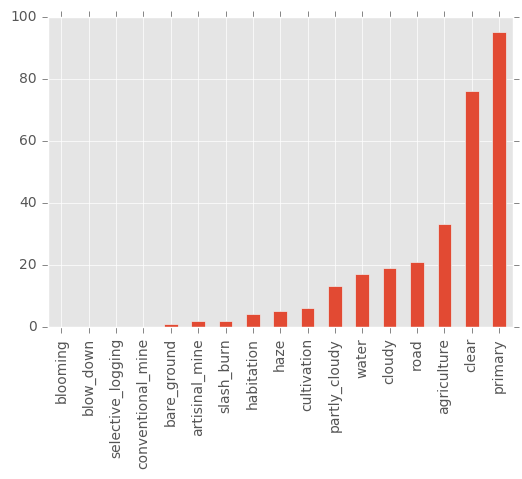

In [8]:
sample.drop(['index', 'image_name', 'tags'], 1).sum().sort_values().plot(kind='bar')

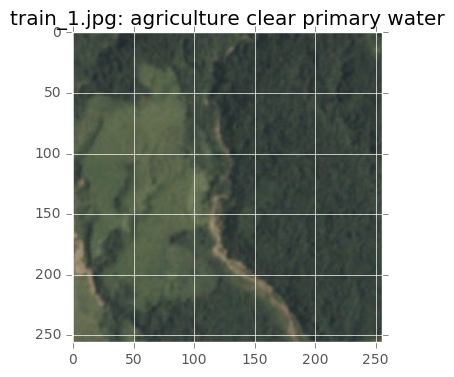

In [9]:
NUM_FILES = 2

for i in range(0, NUM_FILES):
    sample_jpg = image.imread(os.path.join(PLANET_KAGGLE_JPEG_DIR, str(train_jpg_sample[i])))
    plt.imshow(sample_jpg)
    plt.title(str(train_jpg_sample[i]) + ': ' + sample.tags[i])

Now lets learn to work with the GeoTiff Data. We will use some sample functions provided by PlanetLabs.

In [2]:
def load_image(filename):
    """Return a 4D (r, g, b, nir) numpy array with the data in the specified TIFF filename."""
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, PLANET_KAGGLE_TIFF_DIR, filename))
        print('path: ' + str(path))
        if os.path.exists(path):
            with rasterio.open(path) as src:
                b, g, r, nir = src.read()
                return np.dstack([r, g, b, nir])
            
def sample_images(tags, value, n=None):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, str):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & sample[tag] == value
    if n is not None:
        return sample[condition].sample(n)
    else:
        return sample[condition]

Lets target our analysis to one particular type of tag. We will start with _cloudy_ images.

path: /Users/user/kaggle/input/amazon/train-tif/train_0.tif


/Users/user/anaconda/envs/py35/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


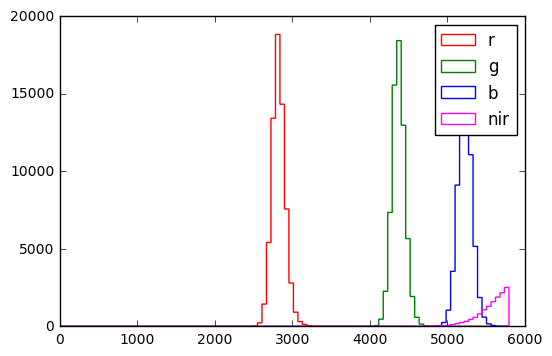

In [ ]:
# get labels for these files
sample = train
# cloud_image_path = sample_images(['cloudy'], n=1, value=1)['image_name'].iloc[0] # fix bug here

cloud_image_path = 'train_0'

rgbn_image = load_image(cloud_image_path + '.tif')
rgb_image = rgbn_image[:,:,:3]
r, g, b, nir = rgbn_image[:, :, 0], rgbn_image[:, :, 1], rgbn_image[:, :, 2], rgbn_image[:, :, 3]
for slice_, name, color in ((r,'r', 'red'),(g,'g', 'green'),(b,'b', 'blue'), (nir, 'nir', 'magenta')):
    plt.hist(slice_.ravel(), bins=100, 
             range=[0,rgb_image.max()], 
             label=name, color=color, histtype='step')
plt.legend()

fig = plt.figure()
fig.set_size_inches(12, 4)
for i, (x, c) in enumerate(((r, 'r'), (g, 'g'), (b, 'b'), (nir, 'near-ir'))):
    a = fig.add_subplot(1, 4, i+1)
    a.set_title(c)
    plt.imshow(x)
plt.show()